In [1]:
import pandas as pd

commentaries = pd.read_csv('../scrapper/commentaries.csv')
commentaries.head()

,pg_index,commentary_source,commentary,score
0,0,supervasco,A3 é como se fosse terceira divisão?,0
1,0,supervasco,PARABÉNS MENINAS!!GRANDE VITÓRIA E UM TÍTULO I...,2
2,1,supervasco,"O olha que temos uma torcida com alguns ""rifug...",1
3,1,supervasco,Ainda tem torcedor que critica o Vasco dizendo...,2
4,2,supervasco,"Adeus, Broxedes.",0


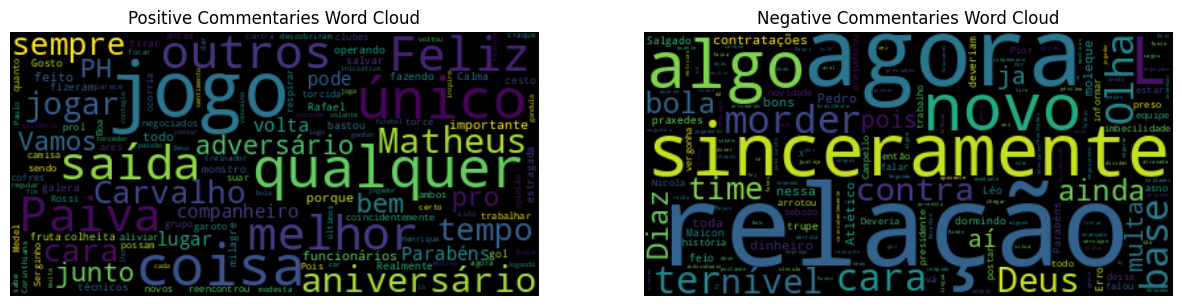

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from stop_words import get_stop_words


positive_commentaries = commentaries[commentaries['score'] == 2]['commentary']
negative_commentaries = commentaries[commentaries['score'] == 0]['commentary']

sample_positive = ' '.join(text for text in positive_commentaries.sample(frac=0.1, random_state=42))
sample_negative = ' '.join(text for text in negative_commentaries.sample(frac=0.1, random_state=42))

stop_words = get_stop_words('portuguese')
stop_words.extend(['Vasco', 'é', 'pra', 'caso', 'vai', 'deu', 'vão', 'clube', 'ca'])

wordcloud_positive = WordCloud(stopwords=stop_words).generate(sample_positive)
wordcloud_negative = WordCloud(stopwords=stop_words).generate(sample_negative)

plt.figure(figsize=(15, 7.5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Commentaries Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Commentaries Word Cloud')
plt.axis("off")

plt.show()

In [3]:
from LeIA import SentimentIntensityAnalyzer

leia = SentimentIntensityAnalyzer()
commentaries['leia_score'] = commentaries['commentary'].apply(lambda c: leia.polarity_scores(c))

def compound_analysis(compound):
    if compound >= 0.5:
        return 2
    elif compound <= -0.5:
        return 0
    else:
        return 1

commentaries['compound'] = commentaries['leia_score'].apply(lambda dict: dict['compound'])
commentaries['sentiment'] = commentaries['compound'].apply(compound_analysis)
commentaries.head()

,pg_index,commentary_source,commentary,score,leia_score,compound,sentiment
0,0,supervasco,A3 é como se fosse terceira divisão?,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
1,0,supervasco,PARABÉNS MENINAS!!GRANDE VITÓRIA E UM TÍTULO I...,2,"{'neg': 0.093, 'neu': 0.556, 'pos': 0.351, 'co...",0.8177,2
2,1,supervasco,"O olha que temos uma torcida com alguns ""rifug...",1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
3,1,supervasco,Ainda tem torcedor que critica o Vasco dizendo...,2,"{'neg': 0.197, 'neu': 0.646, 'pos': 0.157, 'co...",-0.3348,1
4,2,supervasco,"Adeus, Broxedes.",0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1


In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(commentaries['score'], commentaries['sentiment'])

0.4052863436123348

In [5]:
from transformers import pipeline

dssc = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    top_k=1
)

def dssc_applier(c):
    try:
        d = dssc(c)[0]['label']
    except Exception:
        d = 'NEUTRAL'
    
    classification_map = {
        'POSITIVE': 2,
        'NEUTRAL': 1,
        'NEGATIVE': 0
    }
    return classification_map[d]

commentaries['sentiment_bert'] = commentaries['commentary'].apply(dssc_applier)

/home/pedro/Desktop/sentimental_vasco/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


In [6]:
accuracy_score(commentaries['score'], commentaries['sentiment_bert'])

0.29955947136563876